<div style="text-align: center;">
    <h1> Evaluating the Performance of Nighttime Light (NTL) and Built Area Structure in Predicting Deprivation Indices: A Case Study of Greater London </h1>
</div>

*Word count: 1972*

## 1. Introduction

In today's era, the need for data has become essential in formulating public policy for urban environment in the United Kingdom. However, there are cases where crucial data, such as deprivation data, is not found or is not up-to-date. Formally, comprehensive deprivation data is obtained through a 10-year census (ONS, 2023). Being available only once in every decade, this deprivation data is too static to balance the more dynamic real urban problems (Robert, 1971).

On the other side, the advancement of technology shows a potential to address census data limitations, including through the usage of satellite imagery. In nature, satellite imagery data is produced in real-time manner at relatively short intervals and covers a global scale. If this satellite image potential is used to extract crucial deprivation-related information (similar to what a census does), there is potential to enhance the performance of evidence-based public policy making.

Based on this background, this research is conducted with the aim of **evaluating the performance of one type of satellite image, namely nighttime light reflectance (NTL) and built environment structure, in estimating deprivation indices with the case study in Greater London in 2019**.

## 2. Literature Review

In fact, there are several studies that attempted to use satellite imagery to estimate socio-economic variables. The potential of using NTL to predict social variables can be observed first in the research by Jean et al., (2016), where they attempted to classify nighttime light intensity from spatial objects in daylight imagery using Convolutional Neural Network (CNN). The aim of this research was to estimate whether built structures could serve as a good proxy for predicting socio-economic variables akin to nighttime light. At the end of the study, it was found that daytime objects could predict nighttime light intensity with an accuracy rate of 70%. This indicates that built structures have significant potential as predictor variables.

In the same year, Jean et al., (2016) used the results of their research to predict poverty levels -symbolized by two operational variables, namely average expenditure and asset wealth- using ridge regression. The results showed that built structures could explain 37-55% of the variation in average consumption and 55-70% for asset wealth which is relatively good. On the other side, Head et al., (2017) undertook a similar approach but with a different metric: the Human Development Indices (HDI) constructed by wealth, education, access to clean water, electricity and telecommunications, and health components. The results of this study showed that while the prediction process for wealth and education indicators in sub-Saharan Africa went well, predictions using the same indicators in different locations proved to be less effective. Moreover, variables other than wealth and education showed higher variation everywhere. Based on these findings, this method was less effective for HDI indices.

## 3. Research Question

Based on the introduction and literature review above, the research question generated for this research is: **are NTL and built structure good predictors for the deprivation indices in Greater London in the terms of Accuracy (R2) and Variability (RMSE)?**

## 4. Methodology

To measure the performance of NTL and built structure in predicting deprivation indices, a supervised learning approach is used. In other words, the estimates produced by these predictors will be compared with ground-truth data (labelled data) to assess how accurately these predictors predict metric values. The complete process related to this procedure can be illustrated as follows.

<div style="text-align:center;"><img src="https://www.dropbox.com/scl/fi/3yex2sko0hikbo07zj2x0/workflow.jpg?rlkey=9fa8tejk6hbtd29h8p8955ynh&dl=1" /></div>

### 4.1. Data Preparation

- **Nighttime Lights (NTL)** (Elvidge et al., 2021): Acquired from Annual global of Visible and Infrared Imaging Suite (VIIRS) nighttime lights dataset (with the spatial resolution of 375-750 meters). There are six bands that are representing the light intensity (average, average_masked, maximum, median, median_masked, minimum) with the units of nanoWatts/sr/cm^2. For this research, median band is used because this value is good in representing the skewed data (Central Statistics Office, 2023).
- **The Normalized Difference Built-up Index (NDBI)** is the index to emphasize manufactured built-up areas. It needs the shortwave infrared band (SWIR-6) and near-infrared band (NIR-5) mitigate the effects of terrain illumination differences as well as atmospheric effects (Kafy and Mohammad Hasib & Islam, 2020). To calculate this index, the Sentinel-2 multispectral imagery which has a spatial resolution of 20-60 m is used.
- **The Gray-Level Co-Occurrence Matrix (GLCM)** complements the NDBI to describe the characteristic of built environment. This value differentiate the texture of built environment by calculating how often pairs of pixel with specific values and in a specified spatial relationship occur in an image (MathWorks, 2024). The same with NDBI, it uses Sentinel-2 Band 8 (visible and near infrared/VNIR) to calculate this matrix.
- **London Deprivation Indices 2019**, consists of eight indices (Composite, income, employment, education, health, crime, housing, environment deprivation scores) that measure the score of deprivation of each LSOAs. The data has also been normalized by the number of population. The greater of their value, the higher deprivation level  estimated on that area (Greater London Authority, 2020).

Here is the code that is used for collecting satellite imagery data in Google Earth Engine (GEE): [Script in GEE](https://code.earthengine.google.com/2725762d6baabd95660773098f7e3759)

```js

var london_ward = ee.FeatureCollection('projects/ee-ofitrahramadhan/assets/LSOA_2011_London_gen_MHW')
var year = '2019'

//____________________________NIGHTTIME_________________________________


//load  nighttime satellite imagery
var nighttime = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG")
                  .filter(ee.Filter.date(year+'-01-01', year+'-11-01'))
                  .select('avg_rad')
                  .reduce(ee.Reducer.median());

//nighttime for wards
var nighttime = nighttime.reduceRegions({
  reducer: ee.Reducer.median(),
  collection: london_ward,
  scale: 30
});

//rename column
var nighttime = nighttime.map(function(feat){
  return ee.Feature(feat.geometry(), { 
    lsoa_code: feat.get('LSOA11CD'),
    light_intensity: feat.get('median')
  })
})

//_______________________________NDBI_________________________________

//mask out cloud
function maskS2clouds(image) {
  var qa = image.select('QA60')

  var cloudBitMask = 1 << 10;
  var cirrusBitMask = 1 << 11;

  var mask = qa.bitwiseAnd(cloudBitMask).eq(0).and(
             qa.bitwiseAnd(cirrusBitMask).eq(0))

  return image.updateMask(mask)
      .select("B.*")
      .copyProperties(image, ["system:time_start"])
}

//load  spectral imagery
var collection = ee.ImageCollection('COPERNICUS/S2')
    .filterDate(year+'-01-01', year+'-12-31')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .map(maskS2clouds)
    .median()

//create ndbi
// Normalized Difference Built-Up Index          
var ndbi=(collection.select('B11')
          .subtract(collection.select('B8')))
          .divide(collection.select('B11')
          .add(collection.select('B8')))
          .select(['B11'],['NDBI'])

//ndbi for wards
var ndbi = ndbi.reduceRegions({
  reducer: ee.Reducer.median(),
  collection: london_ward,
  scale: 30
});

//rename column
var ndbi = ndbi.map(function(feat){
  return ee.Feature(feat.geometry(), { 
    lsoa_code: feat.get('LSOA11CD'),
    ndbi_median: feat.get('median')
  })
})


//_______________________________GLCM_________________________________


var glcm=collection.toUint16().select('B8').select("B8").glcmTexture({size: 4})
            .select(['B8_contrast']);

//ndbi for wards
var glcm = glcm.reduceRegions({
  reducer: ee.Reducer.median(),
  collection: london_ward,
  scale: 30
});

//rename column
var glcm = glcm.map(function(feat){
  return ee.Feature(feat.geometry(), { 
    lsoa_code: feat.get('LSOA11CD'),
    glcm_median: feat.get('median')
  })
})

//_______________________________NDVI_________________________________


var ndvi=(collection.select('B8')
          .subtract(collection.select('B4')))
          .divide(collection.select('B8')
          .add(collection.select('B4')))
          .select(['B8'],['NDVI'])

//ndbi for wards
var ndvi = ndvi.reduceRegions({
  reducer: ee.Reducer.median(),
  collection: london_ward,
  scale: 30
});

//rename column
var ndvi = ndvi.map(function(feat){
  return ee.Feature(feat.geometry(), { 
    lsoa_code: feat.get('LSOA11CD'),
    ndvi_median: feat.get('median')
  })
})

//_______________________________EXPORT_______________________________

// Define export parameters for CSV export
var exportParams1 = {
  collection: nighttime,
  description: 'nighttime_'+year,
  folder: 'dsss_new',
  fileFormat: 'CSV'
};

// Define export parameters for CSV export
var exportParams2 = {
  collection: ndbi,
  description: 'ndbi_'+year,
  folder: 'dsss_new',
  fileFormat: 'CSV'
};

// Define export parameters for CSV export
var exportParams3 = {
  collection: ndvi,
  description: 'ndvi_'+year,
  folder: 'dsss_new',
  fileFormat: 'CSV'
};

// Define export parameters for CSV export
var exportParams4 = {
  collection: glcm,
  description: 'glcm_'+year,
  folder: 'dsss_new',
  fileFormat: 'CSV'
};

// Start the export to Google Drive
Export.table.toDrive(exportParams1);
Export.table.toDrive(exportParams2);
Export.table.toDrive(exportParams3);
Export.table.toDrive(exportParams4);


//________________________________CHECK_______________________________

//params
var nighttimeVis = {min: 0.0, max: 60.0};
var ndbiVis = {min: -1.0, max: 1.0};
var glcmVis = {min: 0, max: 256};
var ndviVis = {min: -1.0, max: 1.0};

print(london_ward);
print(nighttime);
print(ndbi);
print(glcm);
print(ndvi);

Map.setCenter(-0.1278, 51.5074, 10);
Map.addLayer(london_ward, {}, 'London');
Map.addLayer(nighttime, nighttimeVis, 'Nighttime');
Map.addLayer(ndbi, ndbiVis, 'NDBI');
Map.addLayer(ndvi, ndviVis, 'NDVI');
Map.addLayer(glcm, glcmVis, 'GLCM');
Map.addLayer(london_ward, {}, 'london');

```

### 4.2. Data Analysis

The data that have been gathered are being modelled by 4 supervised learning techniques: **Linear Regression, Random Forest Regressor, Gradient Boosting Regressor, and Artificial Neural Network**. The reason to use more than one techniques is because this research wants to consider the 'no free lunch' theorem in Machine Learning. The theorem said that every machine learning algorithm has a different performance for different problem (Mavuduru, 2020). In this case, it is expected to see a different performance between four algorithms and the algorithm with the best score would be claimed as the maximum performance possible for this task. The detail about these techniques would be explained in more detail in the next section.

In [1]:
#install packages for data processing and analysis (run once)
!pip install numpy
!pip install pandas
!pip install geopandas
!pip install shapely
!pip install scikit-learn
!pip install rfpimp
!pip install xgboost
!pip install tensorflow
!pip install matplotlib
!pip install seaborn
!pip install docutils==0.17.1

In [2]:
#load packages  for data processing and analysis

#standardization
from sklearn.preprocessing import StandardScaler

#packages for manipulating dataframe
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import sklearn

#packages for machine learning
##train-test-split
from sklearn.model_selection import train_test_split, validation_curve

##method 1: Linear Regression (LR)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

##method 2: Random Forest Regressor (RF)
import rfpimp
from sklearn.ensemble import RandomForestRegressor

##method 3: Gradient Boosting Regressor (XGB)
import xgboost
from xgboost import XGBRegressor

##method 4: Artificial Neural Network (ANN)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

##cross validation
from sklearn.model_selection import GridSearchCV

##evaluation metrics (R2 and RMSE)
from sklearn.metrics import r2_score, mean_squared_error

#data visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#citation and bib


pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

2024-04-22 03:39:30.287009: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-22 03:39:32.679955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# check the library version
print("numpy version: {}".format(np.__version__))
print("pandas version: {}".format(pd.__version__))
print("geopandas version: {}".format(gpd.__version__))
print("sklearn version: {}".format(sklearn.__version__))
print("xgboost version: {}".format(xgboost.__version__))
print("tensorflow version: {}".format(tf.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("seaborn version: {}".format(sns.__version__))

numpy version: 1.24.4
pandas version: 2.1.0
geopandas version: 0.14.1
sklearn version: 1.3.0
xgboost version: 2.0.1
tensorflow version: 2.16.1
matplotlib version: 3.7.2
seaborn version: 0.12.2


## 5. Presentation of data

In [4]:
import matplotlib.pyplot as plt
import geopandas as gpd

def map_histogram(df, column_name):
    # Setting canvas with two subplots (map and histogram)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Visualizing the map
    df.plot(column=column_name, cmap='plasma', scheme='Fisher_Jenks', k=7, 
            edgecolor='None', legend=True, legend_kwds={'frameon': True, 'fontsize': 8, 'bbox_to_anchor': (1.0, 0.4), 'title': column_name},
            ax=ax1)
    
    ax1.set_title('Spatial Distribution of ' + column_name + ' 2019', fontsize=15)
    ax1.set_xlabel("Easting")
    ax1.set_ylabel("Northing")
    
    # Visualizing the histogram
    ax2.hist(df[column_name], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
    ax2.set_title('Distribution of ' + column_name + ' 2019')
    ax2.set_xlabel(column_name)
    ax2.set_ylabel('Frequency')
    
    plt.show()

### 5.1. Load LSOAs Administration Map

In [5]:
# load LSOAs administration boundary
lsoa = gpd.read_file('https://www.dropbox.com/scl/fi/impn248gw594znmcmmt7f/lsoa_london.gpkg?rlkey=6m2voo2qn4t1dlrrl4e1zpv3o&dl=1')
lsoa = lsoa[['LSOA11CD','LSOA11NM','MSOA11CD','MSOA11NM','POPDEN','geometry']]

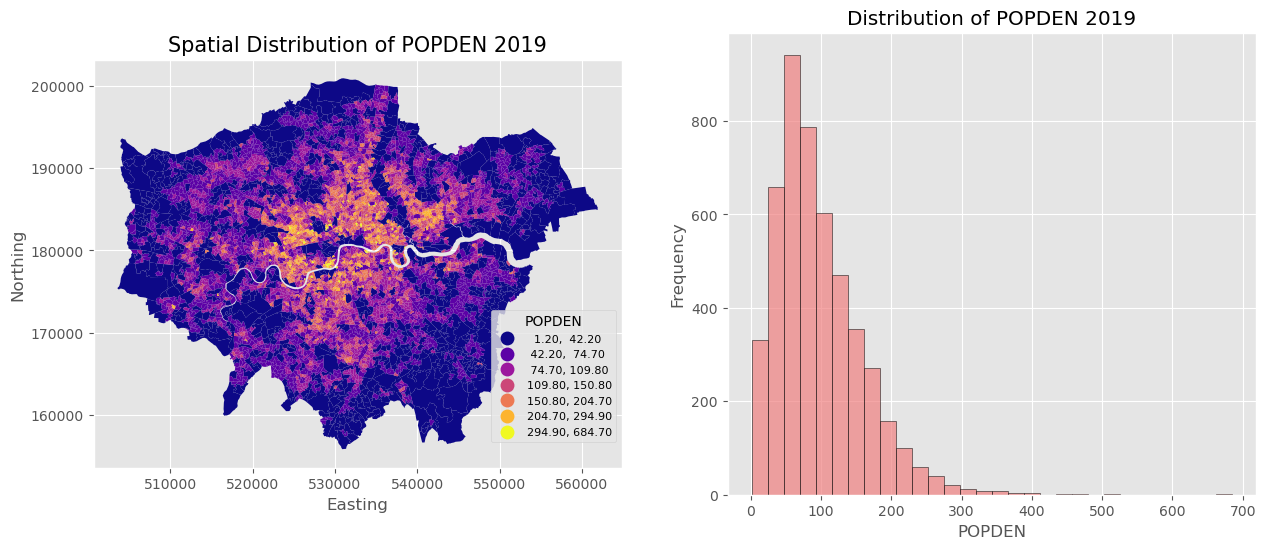

In [6]:
# plot the LSOAs boundary and population density
map_histogram(lsoa, 'POPDEN')

In [7]:
lsoa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   LSOA11CD  4835 non-null   object  
 1   LSOA11NM  4835 non-null   object  
 2   MSOA11CD  4835 non-null   object  
 3   MSOA11NM  4835 non-null   object  
 4   POPDEN    4835 non-null   float64 
 5   geometry  4835 non-null   geometry
dtypes: float64(1), geometry(1), object(4)
memory usage: 226.8+ KB


The map above shows that the Greater London has 4835 LSOAs. This number would be the unit of the analysis where deprivation index and the features will be plotted inside this boundary. Just a small note, if the population density is being mapped on the layer, it can be seen that the normal curve is positively skewed. It means that majority of the areas are less dense where a few areas show the opposite. This distribution is also has a tendency to clustered in the central as the map shows above.

### 5.2. Load Deprivation Indices Data (Label Data)

In [8]:
# load deprivation data (cleaned from https://data.london.gov.uk/dataset/2021-census-wards-demography-and-migration)
depv_idx = pd.read_csv('https://www.dropbox.com/scl/fi/d289a4329r4mnx3qhodyz/imd.csv?rlkey=tqneww32we17j7llp6gwbdztr&dl=1', sep = ';')

# convert the score from object to numeric
columns = ['imd_score','income_score','employment_score','educ_score','health_score','crime_score','housing_score','environtment_score']
for column in columns:
    depv_idx[column] = depv_idx[column].str.replace(',', '.').astype('float64')

depv_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lsoa_code           4835 non-null   object 
 1   lsoa_name           4835 non-null   object 
 2   imd_score           4835 non-null   float64
 3   income_score        4835 non-null   float64
 4   employment_score    4835 non-null   float64
 5   educ_score          4835 non-null   float64
 6   health_score        4835 non-null   float64
 7   crime_score         4835 non-null   float64
 8   housing_score       4835 non-null   float64
 9   environtment_score  4835 non-null   float64
dtypes: float64(8), object(2)
memory usage: 377.9+ KB


In [9]:
# merge the deprivation indices with the lsoa map (for visualization)
lsoa = lsoa.merge(depv_idx, left_on='LSOA11CD', right_on='lsoa_code')
lsoa.drop(['lsoa_code','lsoa_name'], axis=1, inplace=True)

In [10]:
# describe the deprivation indices
depv_idx[columns].describe()

imd_score  \
count                               4,835.0000   
mean                                   21.4984   
std                                    10.9047   
min                                     2.3260   
25%                                    12.4465   
50%                                    20.3750   
75%                                    29.5975   
max                                    64.6770   

                                  income_score  \
count                               4,835.0000   
mean                                    0.1362   
std                                     0.0757   
min                                     0.0060   
25%                                     0.0750   
50%                                     0.1250   
75%                                     0.1890   
max                                     0.4370   

                              employment_score  \
count                               4,835.0000   
mean                                    0.0874   
std                                     0.0468   
min                                     0.0030   
25%                                     0.0510   
50%                                     0.0790   
75%                                     0.1170   
max                                     0.3170   

                                    educ_score  \
count                               4,835.0000   
mean                                   13.0652   
std                                     9.9733   
min                                     0.0130   
25%                                     4.8650   
50%                                    11.1470   
75%                                    19.0030   
max                                    58.9760   

                                  health_score  \
count                               4,835.0000   
mean                                   -0.3834   
std                                     0.7046   
min                                    -3.2150   
25%                                    -0.8340   
50%                                    -0.3130   
75%                                     0.1265   
max                                     1.5700   

                                   crime_score  \
count                               4,835.0000   
mean                                    0.2583   
std                                     0.5712   
min                                    -2.3540   
25%                                    -0.1170   
50%                                     0.2750   
75%                                     0.6370   
max                                     2.3770   

                                 housing_score  \
count                               4,835.0000   
mean                                   31.6237   
std                                     9.7452   
min                                     6.9100   
25%                                    24.5390   
50%                                    30.7800   
75%                                    38.3260   
max                                    70.4560   

                            environtment_score  
count                               4,835.0000  
mean                                   29.2101  
std                                    10.8933  
min                                     5.4500  
25%                                    21.3865  
50%                                    28.5340  
75%                                    35.6465  
max                                    91.6020

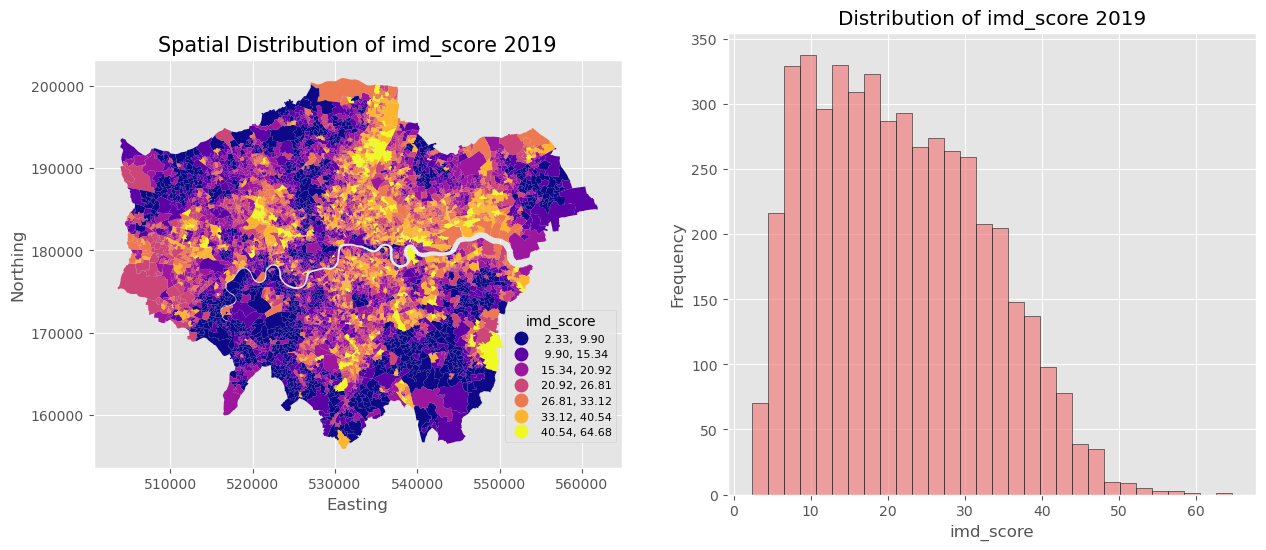

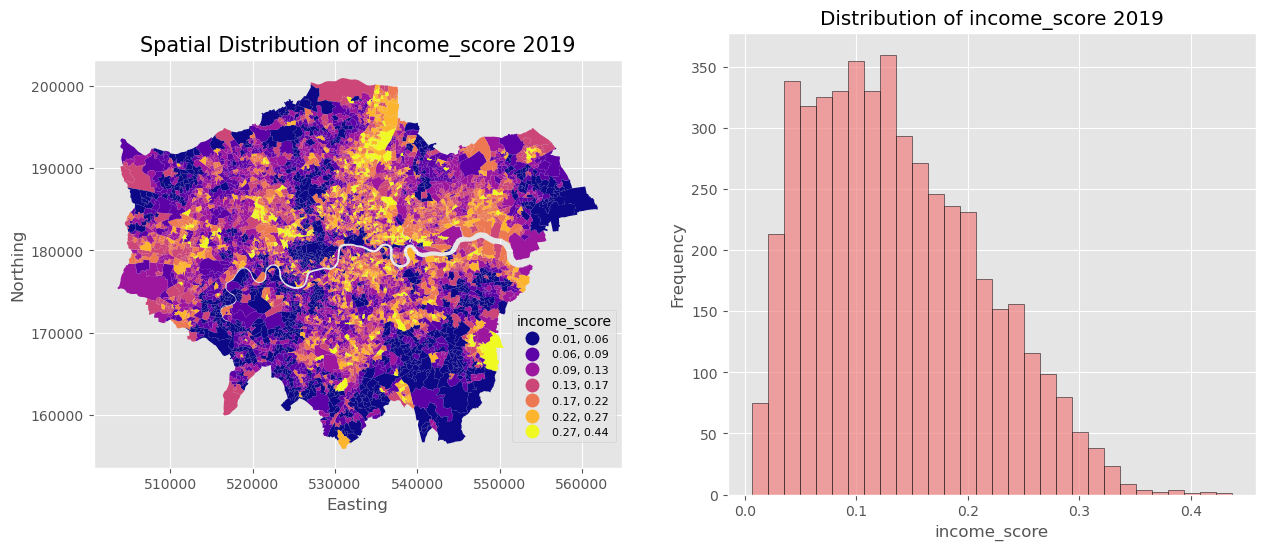

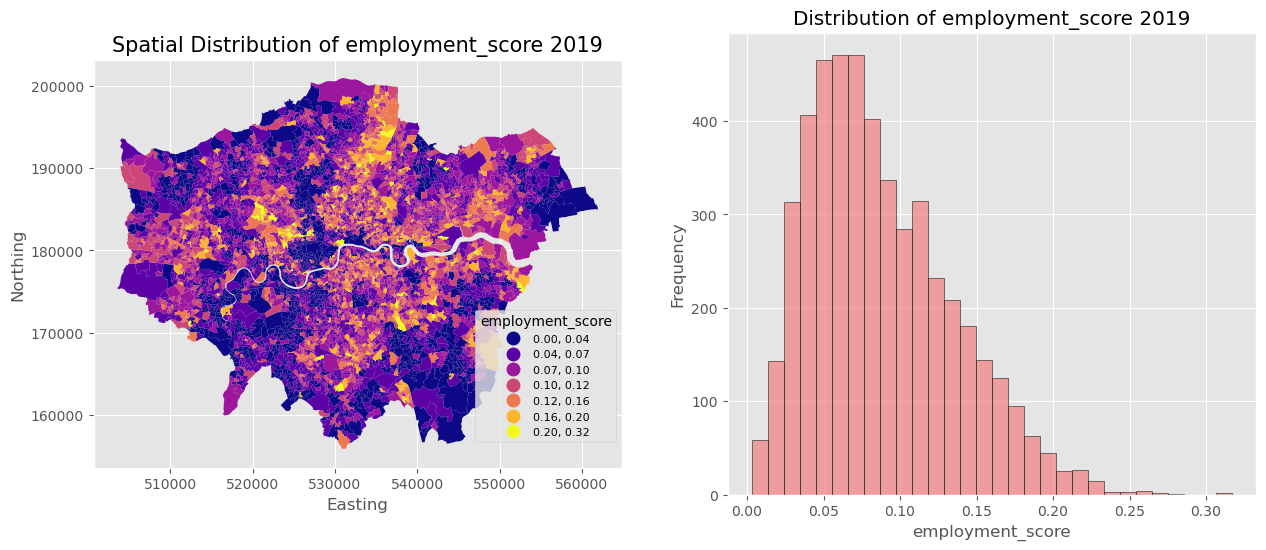

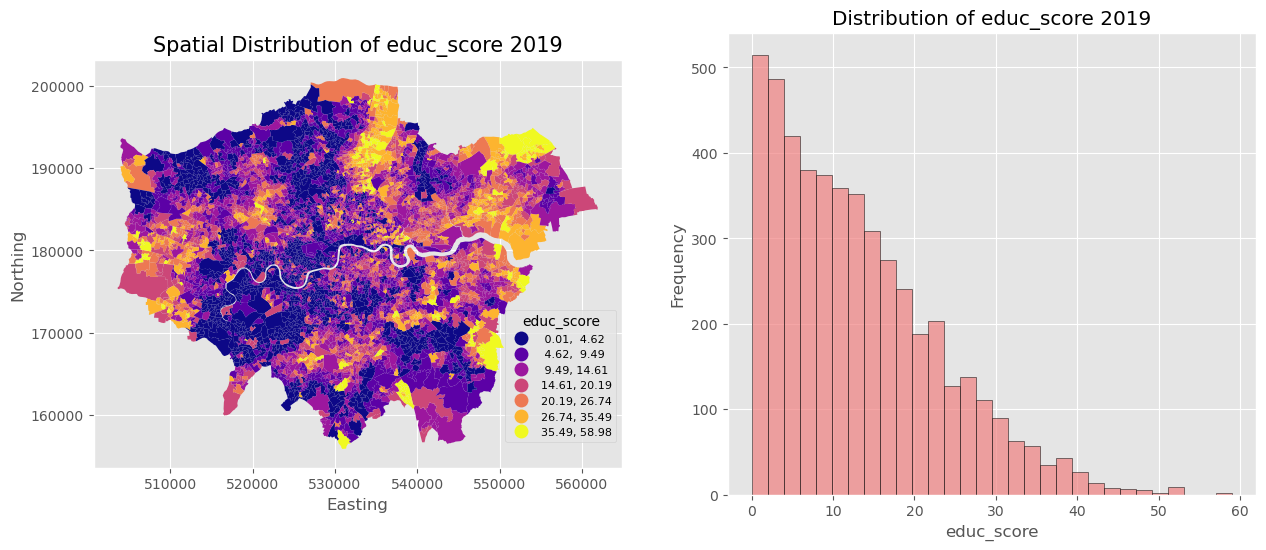

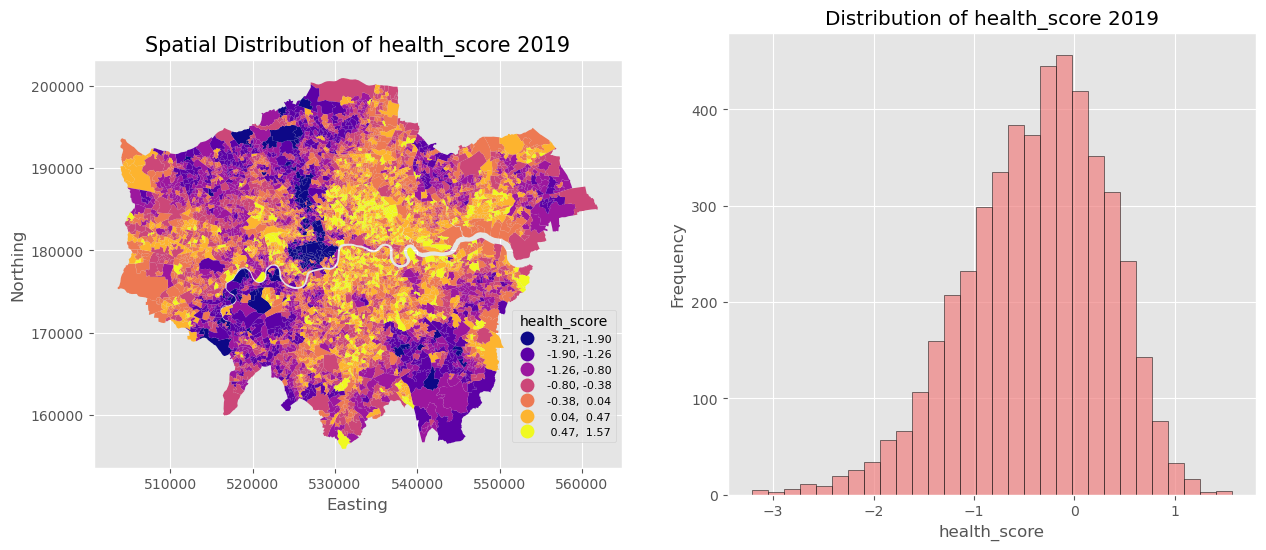

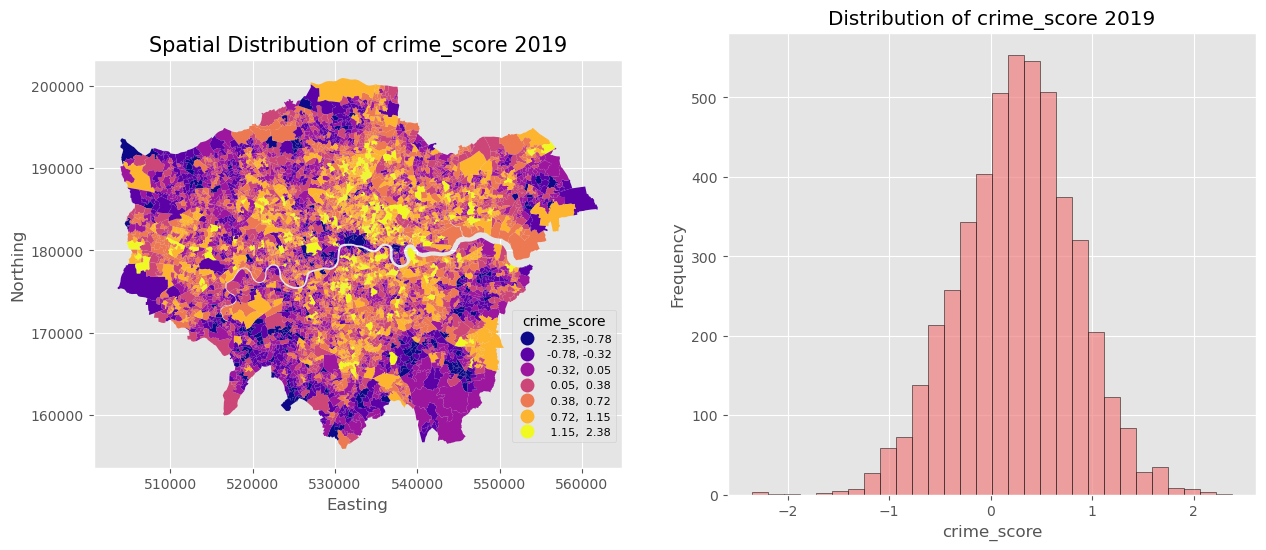

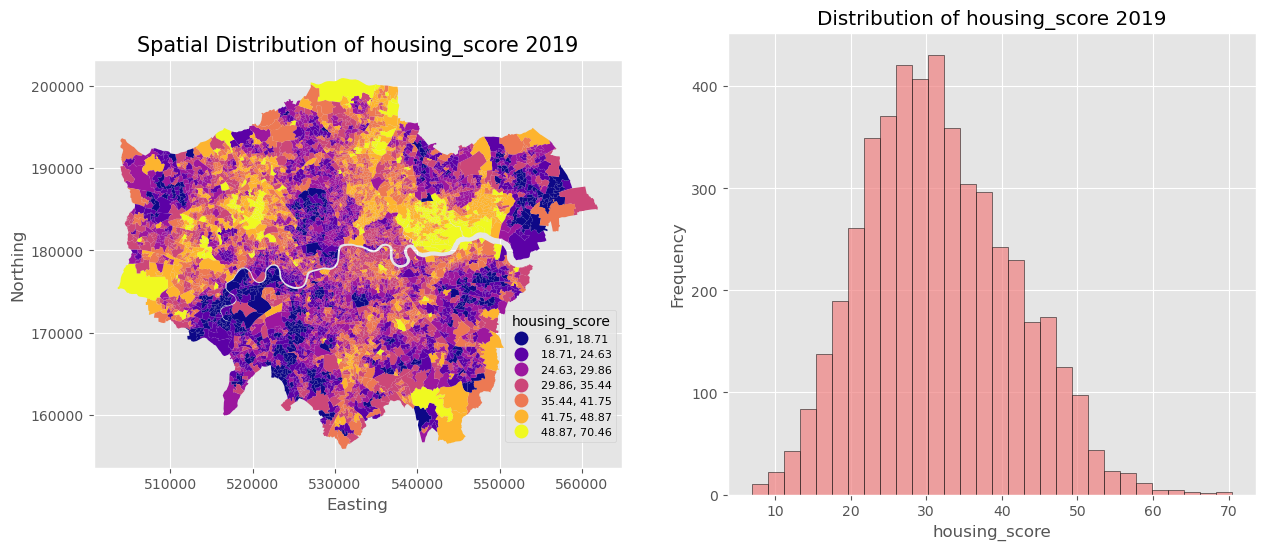

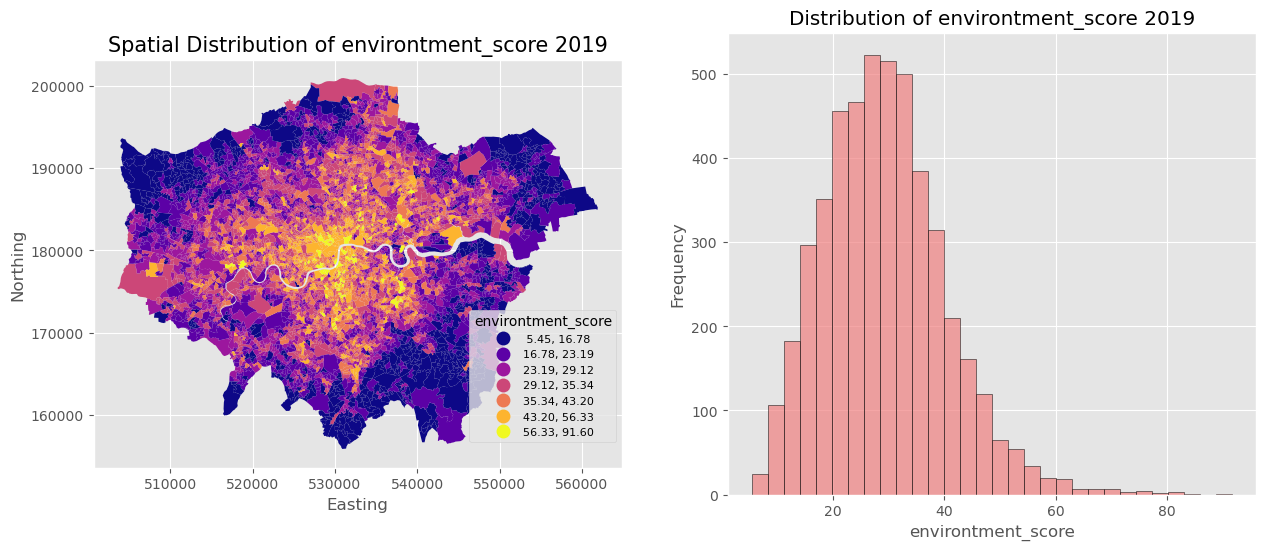

In [11]:
# visualization of depv indices
for col in columns:
    map_histogram(lsoa, col)

Overall, more of the LSOAs have a relatively low deprivation index. This fact can be seen in the histogram and map plot of composite index where the curve is positively skewed. This distribution is being followed by the seemingly random pattern in spatial distribution. Five out of seven individual indices (income, employment, education, housing, and environment) are also showing the similar pattern with the composite index, even though they have a different severity and spatial distribution. Only health and crime deprivation that have a negatively skewed pattern which showing that more of LSOAs have a high level of these deprivation index.

### 5.3. Load Features Data

In [12]:
# load nighttime intensity and ndbi (extracted from GEE)
nighttime19 = pd.read_csv('https://www.dropbox.com/scl/fi/o0pjacmv5dfrhuf7ju1pv/nighttime_2019.csv?rlkey=0ycor4uxy8jlx8hf2cu4k2w62&dl=1', sep=',')
ndbi19 = pd.read_csv('https://www.dropbox.com/scl/fi/6gb74t7uzgrslphntf8jw/ndbi_2019.csv?rlkey=286snw0z27ru2ewod1n1vejz1&dl=1', sep=',')
ndvi19 = pd.read_csv('https://www.dropbox.com/scl/fi/6oiv35gry8yrwdox0rhpr/ndvi_2019.csv?rlkey=90l43sifen6mi2xdxk1r8z70i&dl=1', sep=',')
glcm19 = pd.read_csv('https://www.dropbox.com/scl/fi/k09l3do083uzdex4yobih/glcm_2019.csv?rlkey=4aajyn3vr7prhvn3apmet1uyi&dl=1', sep=',')

In [13]:
# join features data
feature = nighttime19[['lsoa_code','light_intensity']].merge(ndbi19[['lsoa_code','ndbi_median']], on = 'lsoa_code')
feature = feature.merge(glcm19[['lsoa_code','glcm_median']], on = 'lsoa_code')
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   lsoa_code        4835 non-null   object 
 1   light_intensity  4835 non-null   float64
 2   ndbi_median      4835 non-null   float64
 3   glcm_median      4835 non-null   float64
dtypes: float64(3), object(1)
memory usage: 151.2+ KB


In [14]:
# merge features with lsoa map
lsoa = lsoa.merge(feature, left_on='LSOA11CD', right_on='lsoa_code')
lsoa.drop(['lsoa_code'], axis=1, inplace=True)

In [15]:
#describe features data
columns = ['light_intensity','ndbi_median','glcm_median']
feature[columns].describe()

light_intensity  \
count                               4,835.0000   
mean                                   29.5164   
std                                    18.9588   
min                                     1.5847   
25%                                    16.1900   
50%                                    23.5850   
75%                                    38.1275   
max                                   180.0500   

                                   ndbi_median  \
count                               4,835.0000   
mean                                   -0.0642   
std                                     0.0472   
min                                    -0.4072   
25%                                    -0.0923   
50%                                    -0.0567   
75%                                    -0.0293   
max                                     0.0536   

                                   glcm_median  
count                               4,835.0000  
mean                              133,561.2310  
std                                45,490.3247  
min                                26,815.4022  
25%                               101,659.7727  
50%                               128,244.8061  
75%                               161,068.3171  
max                               420,016.3382

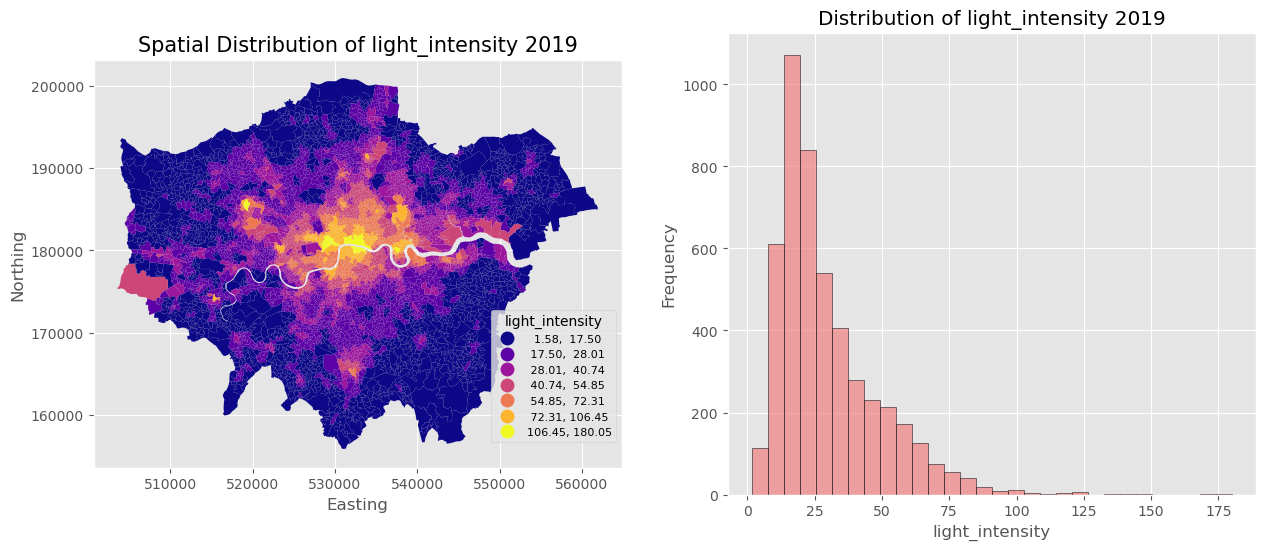

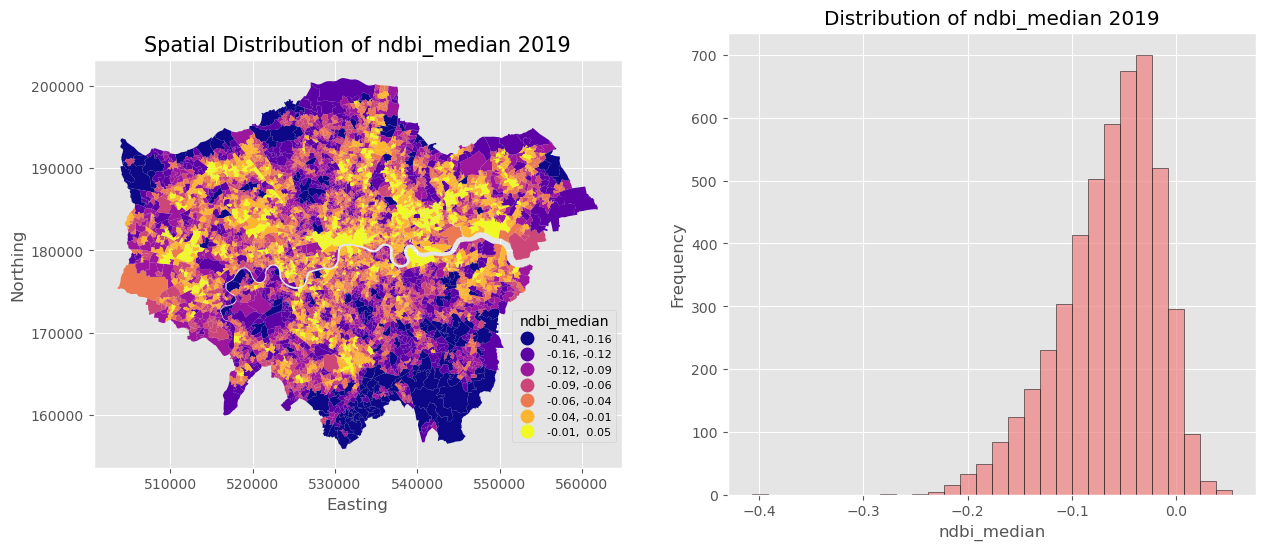

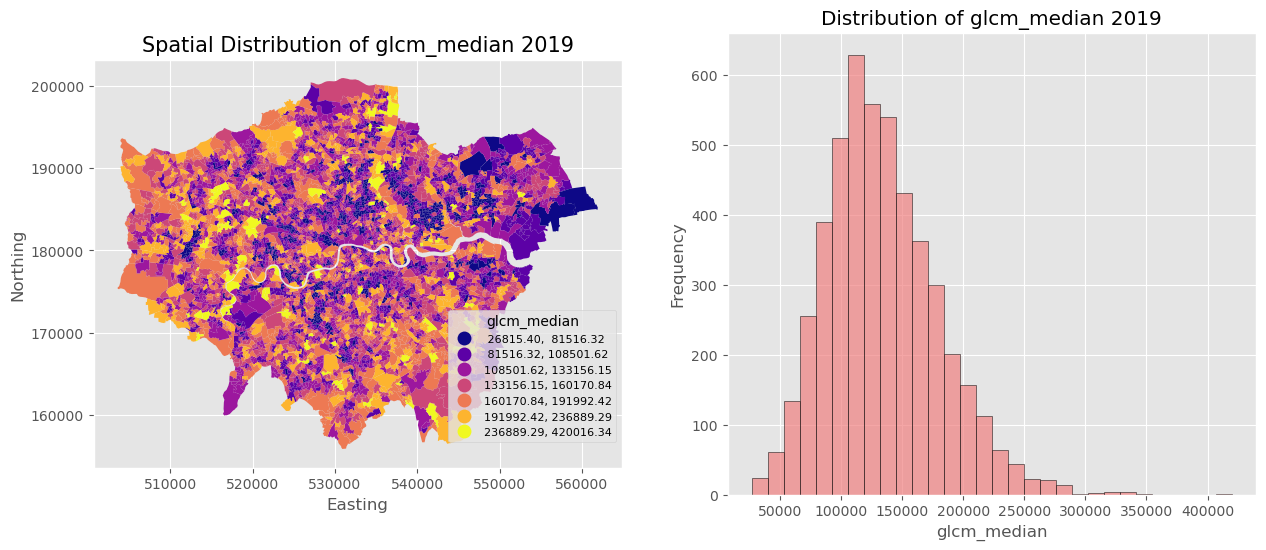

In [16]:
# visualization of depv indices
for col in columns:
    map_histogram(lsoa, col)

Surprisingly, majority of the areas in Greater London during 2019 have a low median light luminousity (positively skewed) with the distribution that is being centralized on the center. However, when it is being compared with the distribution of built up areas (showed by the NDBI value) majority of the areas are built up areas that somehow has simple texture pattern (showed by the GLCM map). 

### 5.4. Prepare the Data for Training and Testing

For conducting the modelling part, the deprivation indices and features should be in the same dataset. Based on this reason, the deprivation index and the spatial features should be merge.

In [17]:
#merge label and feature into one dataset
cdata = depv_idx.merge(feature, on='lsoa_code')
cdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4835 entries, 0 to 4834
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   lsoa_code           4835 non-null   object 
 1   lsoa_name           4835 non-null   object 
 2   imd_score           4835 non-null   float64
 3   income_score        4835 non-null   float64
 4   employment_score    4835 non-null   float64
 5   educ_score          4835 non-null   float64
 6   health_score        4835 non-null   float64
 7   crime_score         4835 non-null   float64
 8   housing_score       4835 non-null   float64
 9   environtment_score  4835 non-null   float64
 10  light_intensity     4835 non-null   float64
 11  ndbi_median         4835 non-null   float64
 12  glcm_median         4835 non-null   float64
dtypes: float64(11), object(2)
memory usage: 491.2+ KB


## 6. Result and Discussion

### 6.1. Function to Measure the Performance

In [18]:
def performance_measurement(df, feature_list, label):

    #split the data into training and testing
    random_state_split = 100
    train_x, test_x, train_y, test_y = train_test_split(df[feature_list], df[label], random_state=random_state_split)

    #_______________________________________________TRAINING__________________________________________________________
    
    #1. training with the linear Regression (LR)
    
    model_lr = LinearRegression()
    model_lr.fit(train_x, train_y)

    #_________________________________________________________________________________________________________________
    
    #2. training with Random Forest Regressor (RF)
    
    # values of max_depth and min_samples_split
    hyperparameters = {'max_depth':[2,5,8,11,14], 'min_samples_split':[2,4,6,8,10]}

    # model random forest
    randomState_dt = 100
    model_rf = RandomForestRegressor(random_state=randomState_dt)

    # cv=5 by default, which means 5-fold cross-validation
    clf = GridSearchCV(model_rf, hyperparameters)
    clf.fit(train_x, train_y)

    #fit the model
    model_rf = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
    model_rf.fit(train_x, train_y)

    #_________________________________________________________________________________________________________________

    #3. training with Gradient Boosting Regressor (XGB)
    
    # values of max_depth and min_samples_split
    hyperparameters = {'max_depth':[2,5,8,11,14], 'n_estimators':[4,8,12,16,20]}

    randomState_xgb = 100
    model_xgb = XGBRegressor(random_state=randomState_xgb)

    # cv=5 by default, which means 5-fold cross-validation
    gscv_xgb = GridSearchCV(model_xgb, hyperparameters)
    gscv_xgb.fit(train_x, train_y)

    #fit the model
    model_xgb = XGBRegressor(max_depth=gscv_xgb.best_params_['max_depth'], n_estimators=gscv_xgb.best_params_['n_estimators'], random_state=randomState_xgb)
    model_xgb.fit(train_x, train_y)

    #_________________________________________________________________________________________________________________

    #4. training with Artificial Neural Network (ANN)

    model_ann = keras.Sequential([
        layers.Input(shape=(3,)),  # Input layer
        layers.Dense(128, activation='relu'),  # Hidden layer with ReLU activation        
        layers.Dropout(0.3),  # Another dropout layer
        layers.Dense(64, activation='relu'),  # Hidden layer with ReLU activation        
        layers.Dropout(0.3),  # Another dropout layer
        layers.Dense(32, activation='relu'),  # Hidden layer with ReLU activation        
        layers.Dropout(0.3),  # Another dropout layer
        layers.Dense(16, activation='relu'),  # Hidden layer with ReLU activation        
        layers.Dropout(0.3),  # Another dropout layer
        layers.Dense(1)  # Output layer
    ])

    #measuring the training with certain metrics
    model_ann.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

    #train the model
    model_ann.fit(train_x, train_y, epochs=100, validation_data=(test_x, test_y))

    #__________________________________________ACCURACY TEST_________________________________________________________

    #1. validation with the linear Regression (LR)
    train_predictions_lr = model_lr.predict(train_x)
    test_predictions_lr = model_lr.predict(test_x)

    r2_train_lr = r2_score(train_y, train_predictions_lr)
    r2_test_lr = r2_score(test_y, test_predictions_lr)

    rmse_train_lr = mean_squared_error(train_y, train_predictions_lr, squared=False)
    rmse_test_lr = mean_squared_error(test_y, test_predictions_lr, squared=False)

    #________________________________________________________________________________________________________________
    
    #2. validation with the Random Forest Regressor (RF)
    train_predictions_rf = model_rf.predict(train_x)
    test_predictions_rf = model_rf.predict(test_x)

    r2_train_rf = r2_score(train_y, train_predictions_rf)
    r2_test_rf = r2_score(test_y, test_predictions_rf)

    rmse_train_rf = mean_squared_error(train_y, train_predictions_rf, squared=False)
    rmse_test_rf = mean_squared_error(test_y, test_predictions_rf, squared=False)

    #________________________________________________________________________________________________________________

    #3. validation with the Gradient Boosting Regressor (XGB)
    train_predictions_xgb = model_xgb.predict(train_x)
    test_predictions_xgb = model_xgb.predict(test_x)

    r2_train_xgb = r2_score(train_y, train_predictions_xgb)
    r2_test_xgb = r2_score(test_y, test_predictions_xgb)

    rmse_train_xgb = mean_squared_error(train_y, train_predictions_xgb, squared=False)
    rmse_test_xgb = mean_squared_error(test_y, test_predictions_xgb, squared=False)

    #________________________________________________________________________________________________________________

    #4. validation with Artificial Neural Network (ANN)
    train_predictions_ann = model_ann.predict(train_x)
    test_predictions_ann = model_ann.predict(test_x)

    r2_train_ann = r2_score(train_y, train_predictions_ann)
    r2_test_ann = r2_score(test_y, test_predictions_ann)

    rmse_train_ann = mean_squared_error(train_y, train_predictions_ann, squared=False)
    rmse_test_ann = mean_squared_error(test_y, test_predictions_ann, squared=False)

    #please input your metrics in here
    metrics_dict = {
    'Algorithm': ['LR','RF','XGB','ANN'],
    "Train R2": [r2_train_lr,r2_train_rf,r2_train_xgb,r2_train_ann],
    "Test R2": [r2_test_lr,r2_test_rf,r2_test_xgb,r2_test_ann],
    "Train RMSE": [rmse_train_lr,rmse_train_rf,rmse_train_xgb,rmse_train_ann],
    "Test RMSE": [rmse_test_lr,rmse_test_rf,rmse_test_xgb,rmse_test_ann]
}

    #create dataframe
    metrics_df = pd.DataFrame(metrics_dict)
    metrics_df.set_index('Algorithm')

    return(metrics_df)

In [19]:
# list the feature and label columns for iteration
feature_list = ['light_intensity','ndbi_median','glcm_median']
label_list = ['imd_score','income_score','employment_score','educ_score','health_score','crime_score','housing_score','environtment_score']

### 6.2. Measure the Performance of NLT and Built Environment to the Composite Deprivation Index

In [20]:
performance_imd = performance_measurement(cdata, feature_list, 'imd_score')

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0000e+00 - loss: 90512480.0000 - val_accuracy: 0.0000e+00 - val_loss: 1774.0835
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 2629682.0000 - val_accuracy: 0.0000e+00 - val_loss: 6509.3096
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 963951.6875 - val_accuracy: 0.0000e+00 - val_loss: 1860.7709
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 499068.7812 - val_accuracy: 0.0000e+00 - val_loss: 214.2651
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 359176.4062 - val_accuracy: 0.0000e+00 - val_loss: 264.0016
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 217486.3906 - val_accuracy: 0.0000e+00 - val_loss: 246.8781
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 132712.2656 - val_accuracy: 0.0000e+00 - val_l

In [21]:
performance_imd

Algorithm                                 Train R2  \
0        LR                                   0.1408   
1        RF                                   0.2840   
2       XGB                                   0.2354   
3       ANN                                  -0.7192   

                                   Test R2  \
0                                   0.1298   
1                                   0.2249   
2                                   0.2145   
3                                  -0.8090   

                                Train RMSE  \
0                                  10.1093   
1                                   9.2288   
2                                   9.5368   
3                                  14.3002   

                                 Test RMSE  
0                                  10.1416  
1                                   9.5714  
2                                   9.6356  
3                                  14.6225

### 6.3. Measure the Performance of NLT and Built Environment to the Income Deprivation Index

In [22]:
performance_income = performance_measurement(cdata, feature_list, 'income_score')

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0000e+00 - loss: 41154240.0000 - val_accuracy: 0.0000e+00 - val_loss: 5555.0991
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 2137385.5000 - val_accuracy: 0.0000e+00 - val_loss: 450.3481
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 847222.7500 - val_accuracy: 0.0000e+00 - val_loss: 249.3195
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 465852.9062 - val_accuracy: 0.0000e+00 - val_loss: 0.0244
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 249765.2500 - val_accuracy: 0.0000e+00 - val_loss: 0.0240
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 132181.4688 - val_accuracy: 0.0000e+00 - val_loss: 0.0243
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 95769.9531 - val_accuracy: 0.0000e+00 - val_loss: 0.02

In [23]:
performance_income

Algorithm                                 Train R2  \
0        LR                                   0.1028   
1        RF                                   0.2298   
2       XGB                                   0.2597   
3       ANN                                  -0.4490   

                                   Test R2  \
0                                   0.0996   
1                                   0.1797   
2                                   0.1698   
3                                  -0.5689   

                                Train RMSE  \
0                                   0.0719   
1                                   0.0666   
2                                   0.0653   
3                                   0.0913   

                                 Test RMSE  
0                                   0.0712  
1                                   0.0680  
2                                   0.0684  
3                                   0.0940

### 6.4. Measure the Performance of NLT and Built Environment to the Employment Deprivation Index

In [24]:
performance_employment = performance_measurement(cdata, feature_list, 'employment_score')

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0000e+00 - loss: 61129900.0000 - val_accuracy: 0.0000e+00 - val_loss: 51892.0312
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 2960422.0000 - val_accuracy: 0.0000e+00 - val_loss: 8990.3955
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 1352241.6250 - val_accuracy: 0.0000e+00 - val_loss: 35.0709
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 655559.0000 - val_accuracy: 0.0000e+00 - val_loss: 0.3724
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 447438.3125 - val_accuracy: 0.0000e+00 - val_loss: 90.6848
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 338452.8125 - val_accuracy: 0.0000e+00 - val_loss: 197.8463
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 268977.1875 - val_accuracy: 0.0000e+00 - val_loss

In [25]:
performance_employment

Algorithm                                 Train R2  \
0        LR                                   0.0587   
1        RF                                   0.1708   
2       XGB                                   0.1567   
3       ANN                                  -1.8896   

                                   Test R2  \
0                                   0.0491   
1                                   0.1044   
2                                   0.0946   
3                                  -2.0330   

                                Train RMSE  \
0                                   0.0451   
1                                   0.0424   
2                                   0.0427   
3                                   0.0791   

                                 Test RMSE  
0                                   0.0461  
1                                   0.0448  
2                                   0.0450  
3                                   0.0824

### 6.5. Measure the Performance of NLT and Built Environment to the Education Deprivation Index

In [26]:
performance_educ = performance_measurement(cdata, feature_list, 'educ_score')

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.0000e+00 - loss: 46908460.0000 - val_accuracy: 0.0000e+00 - val_loss: 980.6274
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 2374567.7500 - val_accuracy: 0.0000e+00 - val_loss: 8958.3018
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 734327.6875 - val_accuracy: 0.0000e+00 - val_loss: 4775.8032
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 398339.7812 - val_accuracy: 0.0000e+00 - val_loss: 330.9906
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 210036.9219 - val_accuracy: 0.0000e+00 - val_loss: 287.6946
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 159586.5156 - val_accuracy: 0.0000e+00 - val_loss: 287.4563
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 79638.2031 - val_accuracy: 0.0000e+00 - val_los

In [27]:
performance_educ

Algorithm                                 Train R2  \
0        LR                                   0.0457   
1        RF                                   0.1344   
2       XGB                                   0.0984   
3       ANN                                  -0.4381   

                                   Test R2  \
0                                   0.0500   
1                                   0.0724   
2                                   0.0687   
3                                  -0.4960   

                                Train RMSE  \
0                                   9.6400   
1                                   9.1812   
2                                   9.3701   
3                                  11.8339   

                                 Test RMSE  
0                                  10.0003  
1                                   9.8816  
2                                   9.9018  
3                                  12.5495

### 6.6. Measure the Performance of NLT and Built Environment to the Health Deprivation Index

In [28]:
performance_health = performance_measurement(cdata, feature_list, 'health_score')

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 8.0500e-04 - loss: 65101252.0000 - val_accuracy: 0.0000e+00 - val_loss: 23978.4902
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 3649628.7500 - val_accuracy: 0.0000e+00 - val_loss: 27775.9844
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 7.0919e-04 - loss: 1359352.2500 - val_accuracy: 0.0000e+00 - val_loss: 0.5935
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 9.7494e-04 - loss: 657879.5000 - val_accuracy: 0.0000e+00 - val_loss: 0.5900
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 9.9719e-04 - loss: 361404.8125 - val_accuracy: 0.0000e+00 - val_loss: 0.5886
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 4.8376e-04 - loss: 187445.6562 - val_accuracy: 0.0000e+00 - val_loss: 0.5873
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 4.3941e-04 - loss: 186841.5312 - val_accuracy: 0.0000e+00 - val_loss: 0

In [29]:
performance_health

Algorithm                                 Train R2  \
0        LR                                   0.1074   
1        RF                                   0.2320   
2       XGB                                   0.1767   
3       ANN                                  -0.0490   

                                   Test R2  \
0                                   0.1007   
1                                   0.1420   
2                                   0.1453   
3                                  -0.0394   

                                Train RMSE  \
0                                   0.6694   
1                                   0.6209   
2                                   0.6429   
3                                   0.7257   

                                 Test RMSE  
0                                   0.6565  
1                                   0.6413  
2                                   0.6401  
3                                   0.7058

### 6.7. Measure the Performance of NLT and Built Environment to the Crime Deprivation Index

In [30]:
performance_crime = performance_measurement(cdata, feature_list, 'crime_score')

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 3.0573e-04 - loss: 49661784.0000 - val_accuracy: 0.0000e+00 - val_loss: 134830.2812
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 6.7872e-04 - loss: 1621354.2500 - val_accuracy: 0.0000e+00 - val_loss: 17609.2305
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.7677e-04 - loss: 611594.7500 - val_accuracy: 0.0000e+00 - val_loss: 4220.7734
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 2.9858e-04 - loss: 321581.5938 - val_accuracy: 0.0000e+00 - val_loss: 1058.0183
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0017 - loss: 178706.4688 - val_accuracy: 0.0000e+00 - val_loss: 638.1033
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 4.3271e-04 - loss: 101185.3047 - val_accuracy: 0.0000e+00 - val_loss: 99.7518
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 5.3556e-04 - loss: 56899.6367 - val_accuracy: 8.2713e-04 - val_los

In [31]:
performance_crime

Algorithm                                 Train R2  \
0        LR                                   0.0858   
1        RF                                   0.2566   
2       XGB                                   0.2878   
3       ANN                                  -0.0482   

                                   Test R2  \
0                                   0.0654   
1                                   0.1664   
2                                   0.1623   
3                                  -0.0703   

                                Train RMSE  \
0                                   0.5449   
1                                   0.4914   
2                                   0.4810   
3                                   0.5835   

                                 Test RMSE  
0                                   0.5553  
1                                   0.5245  
2                                   0.5257  
3                                   0.5942

### 6.8. Measure the Performance of NLT and Built Environment to the Housing Deprivation Index

In [32]:
performance_housing = performance_measurement(cdata, feature_list, 'housing_score')

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0000e+00 - loss: 70564648.0000 - val_accuracy: 0.0000e+00 - val_loss: 303.6628
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 3318854.2500 - val_accuracy: 0.0000e+00 - val_loss: 1128.3693
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 1364924.8750 - val_accuracy: 0.0000e+00 - val_loss: 1128.1821
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0000e+00 - loss: 587124.0000 - val_accuracy: 0.0000e+00 - val_loss: 1127.7395
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 421351.2500 - val_accuracy: 0.0000e+00 - val_loss: 1127.6936
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 215728.2812 - val_accuracy: 0.0000e+00 - val_loss: 1127.2906
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0000e+00 - loss: 245112.6250 - val_accuracy: 0.0000e+00 - va

In [33]:
performance_housing

Algorithm                                 Train R2  \
0        LR                                   0.0454   
1        RF                                   0.2191   
2       XGB                                   0.1754   
3       ANN                                  -2.0256   

                                   Test R2  \
0                                   0.0549   
1                                   0.1738   
2                                   0.1607   
3                                  -2.0902   

                                Train RMSE  \
0                                   9.4835   
1                                   8.5774   
2                                   8.8142   
3                                  16.8832   

                                 Test RMSE  
0                                   9.5651  
1                                   8.9432  
2                                   9.0140  
3                                  17.2959

### 6.9. Measure the Performance of NLT and Built Environment to the Environment Deprivation Index

In [34]:
performance_env = performance_measurement(cdata, feature_list, 'environtment_score')

Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0000e+00 - loss: 41761888.0000 - val_accuracy: 0.0000e+00 - val_loss: 6523.7397
Epoch 2/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 1704883.1250 - val_accuracy: 0.0000e+00 - val_loss: 610.2613
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 713358.2500 - val_accuracy: 0.0000e+00 - val_loss: 606.5851
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 377682.0312 - val_accuracy: 0.0000e+00 - val_loss: 868.3042
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 171318.3438 - val_accuracy: 0.0000e+00 - val_loss: 945.7928
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 161621.9219 - val_accuracy: 0.0000e+00 - val_loss: 972.1596
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 170798.3281 - val_accuracy: 0.0000e+00 - val_los

In [35]:
performance_env

Algorithm                                 Train R2  \
0        LR                                   0.3316   
1        RF                                   0.4586   
2       XGB                                   0.4212   
3       ANN                                  -2.3008   

                                   Test R2  \
0                                   0.3065   
1                                   0.3952   
2                                   0.3916   
3                                  -2.4458   

                                Train RMSE  \
0                                   8.9815   
1                                   8.0830   
2                                   8.3577   
3                                  19.9585   

                                 Test RMSE  
0                                   8.8338  
1                                   8.2492  
2                                   8.2739  
3                                  19.6907

### 6.10. Comparison Across Deprivation Indices

In [36]:
performance_comparison = {
    'task':['composite','income','employment','education','health','crime','housing','environment'],
    'train_R2':[
        performance_imd.loc[performance_imd['Algorithm'] == 'RF', 'Train R2'].values[0],
        performance_income.loc[performance_imd['Algorithm'] == 'RF', 'Train R2'].values[0],
        performance_employment.loc[performance_imd['Algorithm'] == 'RF', 'Train R2'].values[0],
        performance_educ.loc[performance_imd['Algorithm'] == 'RF', 'Train R2'].values[0],
        performance_health.loc[performance_imd['Algorithm'] == 'RF', 'Train R2'].values[0],
        performance_crime.loc[performance_imd['Algorithm'] == 'RF', 'Train R2'].values[0],
        performance_housing.loc[performance_imd['Algorithm'] == 'RF', 'Train R2'].values[0],
        performance_env.loc[performance_imd['Algorithm'] == 'RF', 'Train R2'].values[0]
    ],
    'test_R2':[
        performance_imd.loc[performance_imd['Algorithm'] == 'RF', 'Test R2'].values[0],
        performance_income.loc[performance_imd['Algorithm'] == 'RF', 'Test R2'].values[0],
        performance_employment.loc[performance_imd['Algorithm'] == 'RF', 'Test R2'].values[0],
        performance_educ.loc[performance_imd['Algorithm'] == 'RF', 'Test R2'].values[0],
        performance_health.loc[performance_imd['Algorithm'] == 'RF', 'Test R2'].values[0],
        performance_crime.loc[performance_imd['Algorithm'] == 'RF', 'Test R2'].values[0],
        performance_housing.loc[performance_imd['Algorithm'] == 'RF', 'Test R2'].values[0],
        performance_env.loc[performance_imd['Algorithm'] == 'RF', 'Test R2'].values[0]
    ],
    'best_model':['RF','RF','RF','RF','XGB','RF','RF','RF'  ]
}

performance_comparison_df = pd.DataFrame(performance_comparison)
performance_comparison_df.sort_values('test_R2', ascending=False, inplace=True)
performance_comparison_df

task                                 train_R2  \
7  environment                                   0.4586   
0    composite                                   0.2840   
1       income                                   0.2298   
6      housing                                   0.2191   
5        crime                                   0.2566   
4       health                                   0.2320   
2   employment                                   0.1708   
3    education                                   0.1344   

                                   test_R2 best_model  
7                                   0.3952         RF  
0                                   0.2249         RF  
1                                   0.1797         RF  
6                                   0.1738         RF  
5                                   0.1664         RF  
4                                   0.1420        XGB  
2                                   0.1044         RF  
3                                   0.0724         RF

/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dty

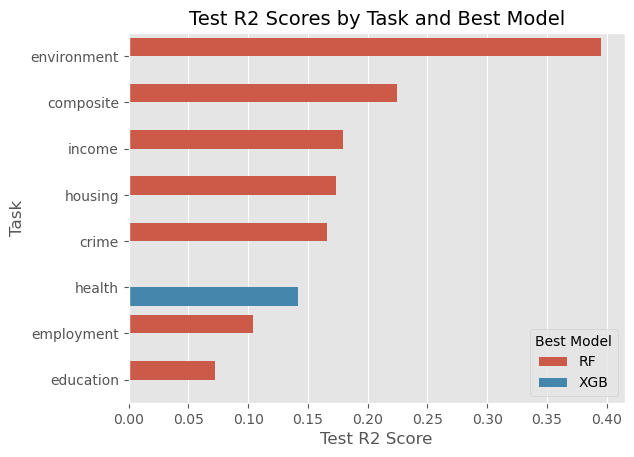

In [37]:
# Plotting using seaborn barplot
ax = sns.barplot(data=performance_comparison_df, y='task', x='test_R2', hue='best_model')

# Customize plot appearance
ax.set_title('Test R2 Scores by Task and Best Model', fontsize=14)  # Set plot title with custom fontsize
ax.set_xlabel('Test R2 Score', fontsize=12)  # Set x-axis label with custom fontsize
ax.set_ylabel('Task', fontsize=12)  # Set y-axis label with custom fontsize
ax.legend(title='Best Model')  # Set legend title

# Show the plot
plt.show()

The graph above shows the performance comparison of NTL and built environments features in predicting various deprivation indices. From the graph, it can be seen that NTL and built environments are relatively in the best performance when they are used to estimate the environmental deprivation index (Test R2 = 39.52%	with the model of random forest), while education deprivation only producing 7.24%. From this point, it can be seen that satellite imagery data, i.e. NTL and built environments have a different performance in predicting various deprivation index.

Interesting to say that the performance of this features is peaked when they are trying to estimate the environmental deprivation which is 'visually visible'. Meanwhile, the performance would gradually decreased when they are used to predict the 'less visible' things, for instance income, crime, health, employment, and education deprivation level.

                                              Importance
Feature                                                 
light_intensity                                   0.7464
glcm_median                                       0.0189
ndbi_median                                       0.0188


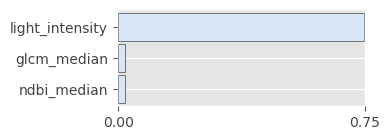

In [38]:
#split the data into training and testing
random_state_split = 100
train_x, test_x, train_y, test_y = train_test_split(cdata[feature_list], cdata['environtment_score'], random_state=random_state_split)

# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[2,5,8,11,14], 'min_samples_split':[2,4,6,8,10]}

# model random forest
randomState_dt = 100
model_rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(model_rf, hyperparameters)
clf.fit(train_x, train_y)

#fit the model
model_rf = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
model_rf.fit(train_x, train_y)

# Calculate and plot the feature importance of the RF model
imp = rfpimp.importances(model_rf, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

Based on the feature importance graph, it can be seen that NTL is greatly contributing towards the prediction of environmental deprivation. Surprisingly, the built environments (NDBI and GLCM) which have been expected to give an equal contribution as NTL, they only give a small amount of contribution to the point it can be excluded from the model without worsening the performance of the model significantly.

## 7. Discussion

So far, it has been found that NTL and built environments features have a vary performance in estimating the multi-dimensional deprivation in Greater London, ranging from 7.2% to 39.5% in the terms of Test R2 where predicting the environmental deprivation is the best performance and predicting the education deprivation gives an opposite result. However, can the value of 7-39.5% is said as the good performance?

A simple findings from Davies, Alsop and Bowes, (2020) when they found that NTL and GDP can form a correlation for about 92% with Malawi as the case study. The number is so high that it almost gives a perfect accuracy in predicting the GDP. The NTL was also being correlated with the Integrated Poverty Index (IPI) which only gave the score of 33%, which is very similar that has been found in the result above. They argument that this is bad performance and the reason of this weak result is because IPI was being constructed from many indices, ranging from economy to social aspectwhich make the prediction weaker.

However, from Lin, Luo and Huang, (2022) research, it resulted 87.96% in performance in predicting poverty index, which is quite high. They argument that the usage of LuoJia1-01 NTL (resolution ~100m) increase the performance in some places in China than only using VIIRS. From this point, it can be said that quality of data and different case study would significantly affect the predicting performance. 

In essence, comparing the result with these findings, it seems that NTL and built environments is not giving a good performance in predicting deprivation index in the context of Greater London.

## 8. Conclusion

Based on the result and discussion above, it can be said that **NTL and Built Environments is not too predictors of deprivation index in Greater London because they are only producing 7.2% to 39.5% in performance.** They are several possibilities why it can be happened:
- NTL and built environment features have a tendency to give only a relatively good performance in predicting 'physically visible metrics' such as environmental deprivation, while the less visible metrics are harder to predict.
- The prediction accuracy is determined by how we define what is deprivation, because different definition of deprivation can lead to different performance.
- The prediction accuracy is also being influenced by the resolution of feature data and case study where a different socio-economic system are operated.

## References

Central Statistics Office (2023). CSO. Available at: https://www.cso.ie/en/releasesandpublications/in/rrppi/meanvsmedianinformationnote/ (Accessed: 22 April 2024).

Davies, K., Alsop, A. and Bowes, J. (2020) ‘Poverty Mapping in Sub Saharan Africa Using Night Time Light Pollution Data’, in 2020 IEEE Global Humanitarian Technology Conference (GHTC). 2020 IEEE Global Humanitarian Technology Conference (GHTC), Seattle, WA, USA: IEEE, pp. 1–4. Available at: https://doi.org/10.1109/GHTC46280.2020.9342875.

Elvidge, C.D. et al. (2021) ‘Annual Time Series of Global VIIRS Nighttime Lights Derived from Monthly Averages: 2012 to 2019’, Remote Sensing, 13(5), p. 922. Available at: https://doi.org/10.3390/rs13050922.

Head, A. et al. (2017) ‘Can Human Development be Measured with Satellite Imagery?’, in Proceedings of the Ninth International Conference on Information and Communication Technologies and Development. ICTD ’17: Ninth International Conference on Information and Communication Technologies and Development, Lahore Pakistan: ACM, pp. 1–11. Available at: https://doi.org/10.1145/3136560.3136576.

Greater London Authority (2020). ‘Indices of Deprivation - London Datastore’. Available at: https://data.london.gov.uk/dataset/indices-of-deprivation (Accessed: 22 April 2024).

Jean, N. et al. (2016) ‘Combining satellite imagery and machine learning to predict poverty’, Science, 353(6301), pp. 790–794. Available at: https://doi.org/10.1126/science.aaf7894.

Kafy, A. and Mohammad Hasib & Islam (2020) ‘Prediction of Future Land Surface Temperature And Its Impact On Climate Change: A Remote Sensing Based Approach In Chattogram City.’

Lin, J., Luo, S. and Huang, Y. (2022) ‘Poverty estimation at the county level by combining LuoJia1-01 nighttime light data and points of interest’, Geocarto International, 37(12), pp. 3590–3606. Available at: https://doi.org/10.1080/10106049.2020.1870166.

MathWorks (2024). Create a Gray-Level Co-Occurrence Matrix - MATLAB & Simulink. Available at: https://www.mathworks.com/help/images/create-a-gray-level-co-occurrence-matrix.html (Accessed: 22 April 2024).

Mavuduru, A. (2020) What “no free lunch” really means in machine learning, Medium. Available at: https://towardsdatascience.com/what-no-free-lunch-really-means-in-machine-learning-85493215625d (Accessed: 22 April 2024).

ONS (2023) How life has changed in City of London: Census 2021. Available at: http://sveltekit-prerender/visualisations/censusareachanges/E09000001/ (Accessed: 22 April 2024).

Robert, E., Barraclough (1971) ‘Limitations of census data for transportation planning and needed programs.’, Highway Research Board Special Report [Preprint].